In [919]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.stats import expon
from scipy.stats import uniform
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import least_squares

We start off by defining our patients' utility function standalone, to be used in the rest of the code.
Note: Unlike in the paper, we use the letter 'k' rather than a greek 'κ' for ease of coding. We write out 'gamma' in the code itself, though in the comments we'll sometimes make use of 'γ' for spacing constraints.

In [920]:
def utility(ki,gammai,kj,Vj,t):
    """
    Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place

    Arguments:
        ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
        gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
        kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
        Vj: J x 1 vector of doctors' "service quality", V_j parameter.
        t: parametrized cost of visit.
    """

    # Reshaping parameters to ensure proper broadcasting
    ki = np.array(ki).reshape((1,-1))             # 1 x I
    gammai = np.array(gammai).reshape((1,-1))     # 1 x I
    kj = np.array(kj).reshape((-1,1))             # J x 1
    Vj = np.array(Vj).reshape((-1,1))             # J x 1

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
                    # This way γ_i is summed if patient i's κ_i is above doctor j's threshold κ_j.

We will define search methods as classes, where their main attributes will be the I x J matrix of patients' strategies --containing each s_ij, i.e. the probability that patient i will visit doctor j--, and the I x J matrix of each d s_ij / d κ_j, i.e. the derivative of s_ij over doctor j's threshold κ_j.

In [921]:
def LogitSearch_derivative(n, J = 3):
    # nth derivative
    # J-sized vector (I go with 3 by default)

    # Define prerequisite symbols
    k = sp.Symbol('k')
    λ = sp.Symbol('λ')
    U = sp.Function('λ')(k)

    # Collection of Vj's and U(i)j's
    V_symbols = sp.symbols(f'V1:{J+1}')
    U_functions = [sp.Function(f'U{j+1}')(k) for j in range(J)]

    # For simplicity we forego the free disposal requirement
    alpha_function = sp.exp(λ*U)

    # We recreate the alpha(i)j matrix
    alpha_matrix = sp.Matrix([alpha_function.subs(U,U_functions[j]) for j in range(J)])
    alpha_total = sum(alpha_matrix)
    # We recreate the Si vector of patient i's strategies over j
    # By dividing the alpha matrix by its total
    Si = alpha_matrix / alpha_total

    # We take the first component as an example for the rest
    example = sp.simplify(
        sp.diff(Si,k,n).subs(
        (sp.diff(U_functions[j],k),V_symbols[j]) for j in range(J)
        ).subs(         # We impose that dUj/dk = Vj
            (sp.diff(V_symbols[j],k),0) for j in range(J)
            )[0]        # We impose that dVj/dk = 0, since it's a scalar
    )

    return example

In [431]:
LogitSearch_derivative(2)

λ*(V1*(exp(λ*U1(k)) + exp(λ*U2(k)) + exp(λ*U3(k))) - V1*exp(λ*U1(k)) - V2*exp(λ*U2(k)) - V3*exp(λ*U3(k)))*exp(λ*U1(k))/(exp(λ*U1(k)) + exp(λ*U2(k)) + exp(λ*U3(k)))**2

In [428]:
def X_derivative(n):
    # Takes the (n + 1)th derivative, because n = 0 is already dX/dk_j 

    # Define prerequisite symbols
    k = sp.Symbol('k')
    gamma = sp.Symbol('gamma')
    s = sp.Function('s')(k,gamma)
    g = sp.Function('g')(gamma)
    f = sp.Function('f')(k)

    # We set up 'int s(k_j,gamma) dG(gamma) f(k_j)'
    integrand = s*g
    integral = sp.integrate(integrand,gamma)
    expression = integral*f
    
    return sp.diff(expression,k,n)

In [562]:
X_derivative(1)

f(k)*Integral(g(gamma)*Derivative(s(k, gamma), k), gamma) + Derivative(f(k), k)*Integral(g(gamma)*s(k, gamma), gamma)

In [922]:
class LogitSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    λ):     # Scalar. Logit shape parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.λ = ki, gammai, kj, Vj, t, λ

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def alpha_matrix(self):
        """
        Intermediate matrix used to compute S matrix of patients' sij's.
        alpha_ij equals e^(λ*uij) if uij > 0, else 0 (free disposal requirement)
        """

        λ = self.λ  # scalar
        U = self.U()  # J x I matrix of uij's

        return np.where(U > 0, np.exp(λ*U), 0)
    
    def S(self):
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  alpha_ij / Σ_j=1^J (alpha_ij)       if      Σ_j=1^J (alpha_ij) > 0
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # alpha_matrix is a J x I matrix where alpha_ij equals e^(λ*uij) if uij > 0, else 0
        alpha_matrix = self.alpha_matrix()
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning      
            return np.where(alphai_total != 0, alpha_matrix/alphai_total, 0)
        
    def dS(self):
        """
        J x I matrix 'S' of the derivative of each patient's s_ij over the respective patient i's
        medical necesity κ_i, i.e. d s_ij / s κ_i.

        Returns:
            a_ij = λ Vj e^(λuij) (Σ_{j=1 to J} e^(λuij)) - e^(λuij) (Σ_{j=1 to J} λ Vj e^(λuij)) 
            b_ij = (Σ_{j=1 to J} e^(λuij))^2 
            d s_ij / s κ_i = a_ij / b_ij

        Output form:
            d s_{i=1,j=1}   d s_{i=2,j=1}   ...   d s_{i=I,j=1}
              d κ_{i=1}       d κ_{i=2}             d κ_{i=I}
            
            d s_{i=1,j=2}       ...                   ...
              d κ_{i=1}
            
            # ...                                     ...

            d s_{i=1,j=J}       ...         ...   d s_{i=I,j=J}
              d κ_{i=1}                             d κ_{i=I}
        """

        alpha_matrix  = self.alpha_matrix()  # J x I matrix of uij's, alpha_ij's resp.
        Vj = self.Vj    # J x 1 vector of physicians' quality Vj
        λ = self.λ  # Scalar. Logit shape parameter.
        Vj = Vj.reshape(-1,1)
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)
        result = np.divide(
            λ*Vj*alpha_matrix*alphai_total 
            - alpha_matrix*np.sum(λ*Vj*alpha_matrix, axis = 0),
            alphai_total**2
            )
        
        return np.where(alphai_total != 0, result, 0)
    
    def d2S(self):
        """
        J x I matrix 'S' of the second derivative of each patient's s_ij over the respective patient i's
        medical necesity κ_i, i.e. d2 s_ij / s κ_i.

        Returns:
            Check out the LogitSearch_derivative() function with n = 2 to look at the syntax.

        Output form:
            d2 s_{i=1,j=1}   d2 s_{i=2,j=1}   ...   d2 s_{i=I,j=1}
              d κ_{i=1}        d κ_{i=2}              d κ_{i=I}
            
            d2 s_{i=1,j=2}       ...                   ...
              d κ_{i=1}
            
            # ...                                     ...

            d2 s_{i=1,j=J}       ...         ...   d2 s_{i=I,j=J}
              d κ_{i=1}                              d κ_{i=I}
        """

        alpha_matrix = self.alpha_matrix()  # J x I matrix of uij's, alpha_ij's resp.
        Vj = self.Vj    # J x 1 vector of physicians' quality Vj
        λ = self.λ  # Scalar. Logit shape parameter.
        Vj = Vj.reshape(-1,1)

        sum_eU = np.sum(alpha_matrix, axis = 0)         # Σ e^(λU) (previously alphai_total)
        sum_VeU = np.sum(Vj*alpha_matrix, axis = 0)     # Σ Ve^(λU)
        sum_V2eU = np.sum((Vj**2)*alpha_matrix, axis = 0)    # Σ V^2 e^(λU)

        result = np.divide(
            (λ**2)*alpha_matrix*(
                (Vj**2)*(sum_eU**2) + 2*(sum_VeU**2)
                - sum_eU*(sum_V2eU + 2*Vj*sum_VeU)
            ),
            sum_eU**3
        )

        return result

    def d3S(self):
        """
        J x I matrix 'S' of the third derivative of each patient's s_ij over the respective
        patient i's medical necesity κ_i, i.e. d3 s_ij / s κ_i.

        Returns:
            Check out the LogitSearch_derivative() function with n = 2 to look at the syntax.

        Output form:
            d3 s_{i=1,j=1}   d3 s_{i=2,j=1}   ...   d3 s_{i=I,j=1}
              d κ_{i=1}        d κ_{i=2}              d κ_{i=I}
            
            d3 s_{i=1,j=2}       ...                   ...
              d κ_{i=1}
            
            # ...                                     ...

            d3 s_{i=1,j=J}       ...         ...   d3 s_{i=I,j=J}
              d κ_{i=1}                              d κ_{i=I}
        """

        alpha_matrix = self.alpha_matrix()  # J x I matrix of uij's, alpha_ij's resp.
        Vj = self.Vj    # J x 1 vector of physicians' quality Vj
        λ = self.λ  # Scalar. Logit shape parameter.
        Vj = Vj.reshape(-1,1)

        sum_eU = np.sum(alpha_matrix, axis = 0)         # Σ e^(λU) (previously alphai_total)
        sum_VeU = np.sum(Vj*alpha_matrix, axis = 0)     # Σ Ve^(λU)
        sum_V2eU = np.sum((Vj**2)*alpha_matrix, axis = 0)    # Σ V^2 e^(λU)
        sum_V3eU = np.sum((Vj**3)*alpha_matrix, axis = 0)    # Σ V^3 e^(λU)

        result = np.divide(
            (λ**3)*alpha_matrix*(
                (Vj**3)*(sum_eU**3) - 6*(sum_VeU**3)
                + 6*sum_eU*sum_VeU*(sum_V2eU + Vj*sum_VeU)
                - (sum_eU**2)*(sum_V3eU + 3*(Vj**2)*sum_VeU + 3*Vj*sum_V2eU)
            ),
            sum_eU**4
        )

        return result


In [692]:
from scipy.stats import rv_continuous

import numpy as np
from scipy.stats import rv_continuous


class F(rv_continuous):
    
    def __init__(self, min_val, max_val):
        # Call the parent class constructor
        super().__init__()
        self.min, self.max = min_val, max_val
    
    def _pdf(self, x):
        # Define the PDF, using self.min and self.max
        min, max = self.min, self.max
        return np.where((x >= min) & (x <= max), 1/(max - min), 0)
    
    def df(self, x):
        # Placeholder for the derivative (df)
        return 0
    
    def d2f(self, x):
        # Placeholder for the second derivative (d2f)
        return 0

# Create an instance of the distribution with min=0 and max=1
dist = F(0, 1)

# Example usage
print("PDF at 0.5:", dist.cdf(0.4))  # Should output 1 (since 0.5 is between 0 and 1)
print("PDF at 1.5:", dist.pdf(1.5))  # Should output 0 (since 1.5 is outside [0, 1])

    
dist.df(0.5)


PDF at 0.5: 0.39999999992617874
PDF at 1.5: 0.0


0

The function 'sij' gives us each patient's Si vector of strategies, and if broadcast correctly it can output all patients' strategies in a single array (given numerable patients in a MC simulation), where each column is each patient’s Si, each row could be added up to a doctor's Qi.

We keep it as a callable function for cases where we want the sij of a particular set of patient x doctor parameters, namely when calculating the derivative of our FOC.

Note on how we treat 'functions' inside our equilibrium class:

We will define the distributions F, G and H as a classes such that its attributes mimick those of scipy distributions, such that one may simply input a scipy distribution instead of making a class from scratch (like we will).

Our physicians' R( ) and P( ) functions will be defined such that they'll take on the same shape for each one, and either a single scalar or a 1 x J vector may be inputed for the parameter slots, and then the actual argument will be doctors' Qj and Xj respectively. We will also define R( ) and P( ) as classes where their evaluation is an attribute, other atttributes including first and second derivatives (in the manner of our search classes), but for flexibility we may initially input an actual function instead of a class as R( ) or P( ), where later attributes requiring derivatives will need them to be manually inputed.

In [961]:
class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        λ,  # Logit parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij): # Search function
       
        self.I, self.F, self.G, self.t, self.λ = I, F, G, t, λ      # Save parameters
        self.R, self.P, self.V, self.sij = R, P, V, sij         

    
    def S(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, λ, V, sij = self.I, self.F, self.G, self.t, self.λ, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V
        kj = k0

        return sij(ki,gammai,kj,Vj,t,λ).S()

    def Q(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)

        return np.sum(S, axis = 1)
    
    def X(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def aux_func(self, k0, func, method = 'at'):
        """
        Vector of int func(k0,gamma) dG(gamma). It's a very useful middle step when defining
        the various n-derivatives of Q and X over k.

        Arguments:
            k0: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            func: Search class function which will be integrated over gamma taking the k-values
                of k0. Possible values: 'S', 'dS', 'd2S', 'd3S'.
            method: Either 'at' (default) or 'over'. 'at' evaluates the integral when k_i is
                right at the threshold, 'over' when the threshold is a bit over k_i.

        Use:
            dX/dk will make use of just the 'at' method, whereas dQ/dk uses both, as it considers
            Si before and after being above the threshold, namely: func('over') - func('at').
                   
        Output form:
            ∫_γ s_func(k1,γ)_{j=1} dG(γ)   ...   ∫_γ s_func(kJ,γ)_{j=1} dG(γ)
            # ...                                 ...
            ∫_γ s_func(k1,γ)_{j=J} dG(γ)   ...   ∫_γ s_func(kJ,γ)_{j=J} dG(γ)
        """

        # We will use this function both for s_func = sij as well as its derivatives
        G, t, λ, V, sij = self.G, self.t, self.λ, self.V, self.sij    # Unpack primitives
        g = lambda x: G.pdf(x)      # Using the pdf for the integral

        if method == 'at':    #Integral where k_j is equal to than k_i
                s_gamma = lambda x: getattr(sij(k0,x,k0,V,t,λ), func)()

        elif method == 'over':    #Integral where k_j is marginally higher than k_i
                
                def S_Modified(k0,gamma,V,t,λ):
                # I should explain this one better (TO-DO, and he never did). Basically, I compare for each doctor j
                # how demand at κ_j changes FOR ALL doctors when j raises his threshold marginally above κ_j.
                # If I do that for each doctor j I'm halfways to a derivative matrix

                    J = len(k0)
                    vectors = []
                    for i in range(J):
                        new_k0 = np.copy(k0)
                        new_k0[i] += 1e-8
                        vectors.append(new_k0)

                    result_matrix = np.zeros((J,J))

                    for idx, vec in enumerate(vectors):
                        ds_dj = getattr(sij(k0[idx],gamma,vec,V,t,λ), func)().reshape(-1)   # Apply the function to each vector
                        result_matrix[:, idx] = ds_dj  # Store the result in the matrix

                    return result_matrix

                s_gamma = lambda x: S_Modified(k0,x,V,t,λ)
        else:
            raise ValueError("Invalid method selected. Please choose 'at' or 'over'.")
        
        # We restrict possible functions to those with defined modules in our search class
        if func not in ['S', 'dS', 'd2S', 'd3S']:
            raise ValueError("Invalid function selected. Please choose 'S', 'dS', 'd2S' or 'd3S'.")
            
        # Evaluate func at each doctor's κj
        # This is a lambda function for a given value of γ
        # Output form:
        # s_func(k1,γ)_j=1   s_func(k2,γ)_j=1     ...     s_func(kJ,γ)_j=1
        # s_func(k1,γ)_j=2   ...                          ...
        # ...
        # s_func(kJ,γ)_j=J   ...                          s_func(kJ,γ)_j=J

        gamma_integrand = lambda x: s_gamma(x) * g(x) # sij(γ) g(γ)

        n = 101
        x = np.linspace(G.ppf(0),G.ppf(1),n) # n-sized linspace across the domain of G

        results = []

        # Loop that evaluates sij(γ) g(γ) for 101 values of γ
        for i in x:
                result = gamma_integrand(i)
                results.append(result)

        results = np.array(results)

        mc_integral = np.sum(results, axis = 0)/n
        # By summing column wise divided by n we get a monte-carlo approximation of an integral

        return mc_integral

    def dQ(self, k0):
        """Computed the jacobian of Q over the vector of κ_j's (physician strategies)"""
        
        F = self.F  # We retrieve our f pdf
        f = lambda x: F.pdf(x)
        
        # We compute both integrals, left and right respectively
        int_over = self.aux_func(k0, func='S', method='over')
        int_at = self.aux_func(k0, func='S', method='at')

        k0 = k0.reshape(-1, 1)  # Reshaping for broadcasting

        return (int_over - int_at) * f(k0)

    def dX(self, k0):
        """Computed the jacobian of X over the vector of κ_j's (physician strategies)"""
         
        F = self.F  # We retrieve our f pdf
        f = lambda x: F.pdf(x)
        
        # We compute both integrals, left and right respectively
        int_over = self.aux_func(k0, func='S', method='over')
        int_at = self.aux_func(k0, func='S', method='at')

        # For the cross derivatives, a small raise in κ_l only affects κ_j in terms of X
        # (certificates granted) if κ_l was above κ_j, meaning j's new expected clientele
        # will get sick leave. For this reason, we compute the following matrix of 1s and 0s
        kj_larger = (k0[:, None] <= k0[None, :]).astype(int)
        # Output form:
        # κ_1 ≤ κ_1     κ_1 ≤ κ_2   ...     κ_1 ≤ κ_J
        # κ_2 ≤ κ_2     ...                 ...
        # ...
        # κ_J ≤ κ_1                         κ_J ≤ κ_J
        # This way the diagonal is also preserved.

        cross_derivatives = kj_larger*(int_over - int_at)
        # The gradient (the change in sij upon doctor j's own threshold) is more straightfoward
        gradient = - int_at

        # We make a matrix of 1s and 0 diagonal, and of 0s with 1 diagonal as multipliers
        J = len(k0)
        cross_multiplier = np.ones((J,J)) - np.eye(J)
        grad_multiplier = np.eye(J)

        k0 = k0.reshape(-1,1)   # Reshaping for broadcasting

        return (cross_multiplier*cross_derivatives + grad_multiplier*gradient) * f(k0)
    
    def utility(self, k0, R, P, s=123):

        Q = self.Q(k0, s)
        X = self.X(k0, s)

        return R(Q) - P(X)

    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)
        dQ = self.dQ(k0)         # Jacobians of Q and J
        dX = self.dX(k0)
        dQ_gradient = np.diagonal(dQ)   # For the FOC we just use the gradient
        dX_gradient = np.diagonal(dX)

        return dR(Q)*dQ_gradient - dP(X)*dX_gradient
    
    def simple_FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)

        return (dR(Q) - dP(X))

    def d2Q(self, k0, df):  # We need the derivative of our choice of f
        """Computed the hessian of Q over the vector of κ_j's (physician strategies)"""
        
        F = self.F  # We retrieve our f pdf
        f = lambda x: F.pdf(x)
        
        # We compute both integrals, left and right respectively
        S_int_over = self.aux_func(k0, func='S', method='over')
        S_int_at = self.aux_func(k0, func='S', method='at')
        # We also compute the derivatives over dS
        dS_int_over = self.aux_func(k0, func='dS', method='over')
        dS_int_at = self.aux_func(k0, func='dS', method='at')

        k0 = k0.reshape(-1, 1)  # Reshaping for broadcasting

        return (S_int_over - S_int_at)*df(k0) + (dS_int_over - dS_int_at)*f(k0)
    
    def d2X(self, k0, df):  # We need the derivative of our choice of f
        """Computed the jacobian of X over the vector of κ_j's (physician strategies)"""
         
        F = self.F  # We retrieve our f pdf
        f = lambda x: F.pdf(x)
        
        # We compute both integrals, left and right respectively
        S_int_over = self.aux_func(k0, func='S', method='over')
        S_int_at = self.aux_func(k0, func='S', method='at')
        # We also compute the derivatives over dS
        dS_int_over = self.aux_func(k0, func='dS', method='over')
        dS_int_at = self.aux_func(k0, func='dS', method='at')

        # We already explain what kj_larger is in dX
        kj_larger = (k0[:, None] <= k0[None, :]).astype(int)

        cross_d = kj_larger*(S_int_over - S_int_at)
        cross_d2 = kj_larger*(dS_int_over - dS_int_at)
        # The gradient (the change in sij upon doctor j's own threshold) is more straightfoward
        gradient_d = - S_int_at
        gradient_d2 = - dS_int_at

        # We make a matrix of 1s and 0 diagonal, and of 0s with 1 diagonal as multipliers
        J = len(k0)
        cross_multiplier = np.ones((J,J)) - np.eye(J)
        grad_multiplier = np.eye(J)

        k0 = k0.reshape(-1,1)   # Reshaping for broadcasting

        return ((cross_multiplier*cross_d + grad_multiplier*gradient_d) * df(k0)
                + (cross_multiplier*cross_d2 + grad_multiplier*gradient_d2) * f(k0))
    
    def dFOC_gradient(self, k0,
             dR, d2R,   # First and second derivatives of R
             dP, d2P,   # First and second derivatives of P
             df, s=123): # Derivative of the pdf

        Q = self.Q(k0, s)
        X = self.X(k0, s)
        dQ = np.diagonal(self.dQ(k0))
        dX = np.diagonal(self.dX(k0))
        d2Q = np.diagonal(self.d2Q(k0, df))
        d2X = np.diagonal(self.d2X(k0, df))

        return (dR(Q)*d2Q - dP(X)*d2X) + (d2R(Q)*dQ - d2P(X)*dX)

In [698]:
J = 2
V = H.rvs(size=J, random_state=rng)
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, logit_search)

x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
X, Y = np.meshgrid(x, y)

# Flatten the grids and stack them as 1x2 vectors
XY = np.stack([X.ravel(), Y.ravel()], axis=1)

func2 = lambda x: np.sum(LogitModel.FOC(x, dR, dP))

# Apply the function to each vector
Z = np.apply_along_axis(func2, 1, XY).reshape(X.shape)

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of func([x, y])')
plt.show()

ValueError: operands could not be broadcast together with shapes (2,10000) (2,) 

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_43707/1157539426.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


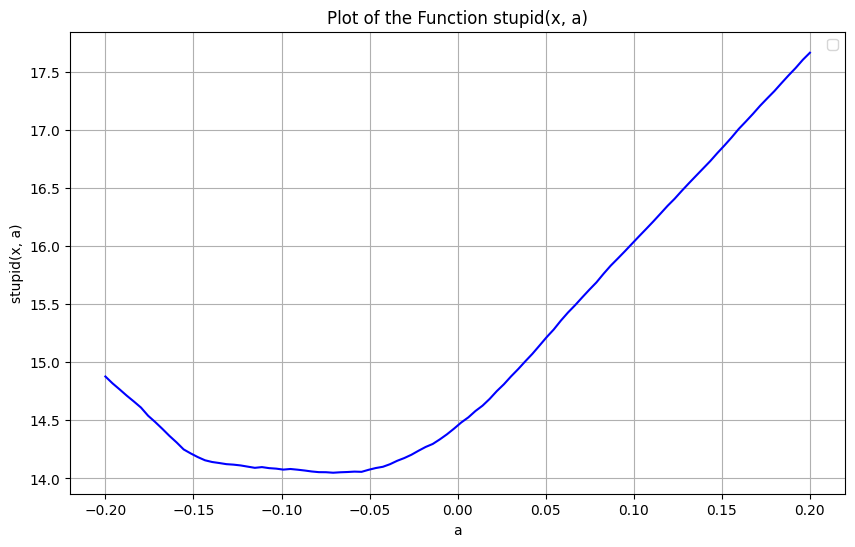

In [64]:
def stupid(x,a):
    x_new = (1+a)*x
    FOC = f(x_new)
    FOC_abs = np.abs(FOC)
    return np.sum(FOC_abs)

# Define a range of values for a
a_values = np.linspace(-0.2, 0.2, 100)  # Adjust range and number of points as needed

# Compute the function values for each a
y_values = np.array([stupid(k, a) for a in a_values])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(a_values, y_values, color='blue')
plt.xlabel('a')
plt.ylabel('stupid(x, a)')
plt.title('Plot of the Function stupid(x, a)')
plt.legend()
plt.grid(True)
plt.show()

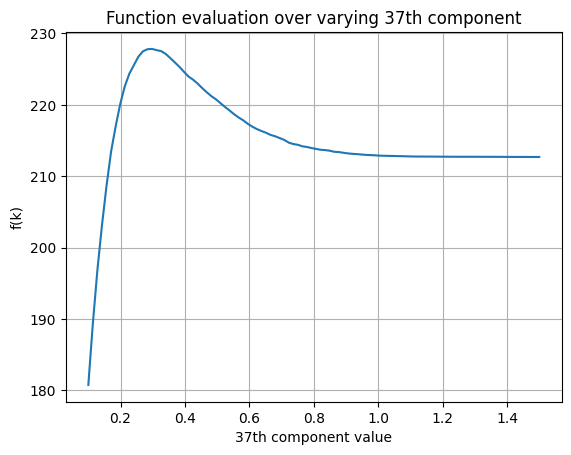

[np.float64(180.75994515940624),
 np.float64(189.3993192349182),
 np.float64(196.91663932225464),
 np.float64(203.1482466924819),
 np.float64(208.6731579776815),
 np.float64(213.45826822969747),
 np.float64(216.9785543916371),
 np.float64(220.10293548904656),
 np.float64(222.58559292847434),
 np.float64(224.35033021008098),
 np.float64(225.562203542714),
 np.float64(226.75596701071316),
 np.float64(227.50428257602752),
 np.float64(227.79528311691044),
 np.float64(227.83404426012146),
 np.float64(227.66107759583593),
 np.float64(227.52230419417884),
 np.float64(227.12906230747717),
 np.float64(226.5500084280897),
 np.float64(225.9417073221628),
 np.float64(225.32600689455208),
 np.float64(224.6301113255192),
 np.float64(223.96515831424296),
 np.float64(223.52503423592722),
 np.float64(222.9768519956573),
 np.float64(222.3489241906583),
 np.float64(221.76003457420433),
 np.float64(221.22368646533886),
 np.float64(220.78018293934167),
 np.float64(220.24128899939967),
 np.float64(219.71183

In [965]:
def graph_component_37(f, k_original, i, start, stop, num_points=100):
    """
    Function to graph the effect of changing the 37th component of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector (must be at least 38 elements long).
    - start: The start value for the 37th component.
    - stop: The stop value for the 37th component.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the 37th component of k changes.
    """
    if len(k_original) < i + 1:
        raise ValueError("Input vector must be at least 38 elements long.")
    
    # Generate a linspace for the 37th component
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components other than the 37th
    k_fixed = np.copy(k_original)
    
    # Store the results of the function evaluations
    results = []

    # Evaluate the function over the linspace
    for value in linspace_values:
        k_fixed[i] = value  # Update the 37th component (index 36 for 0-based indexing)
        result = f(k_fixed)[i] # Evaluate the function
        results.append(result)

    # Plot the results
    plt.plot(linspace_values, results)
    plt.title("Function evaluation over varying 37th component")
    plt.xlabel("37th component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.show()
    
    return results


function = lambda x: LogitModel.utility(x, R, P)

graph_component_37(function, k_guess, 37, 0.1, 1.5, num_points=100)

In [277]:
def newton(f, Df, x_0, tol=1e-7, max_iter=100_000):     # As seen in QuantEcon
    x = x_0

    # Implement the zero-finding formula
    def q(x):
        Df_x = Df(x)  # Compute Df(x) once to avoid redundant calculations
        return np.where(Df_x == 0, 0, x - f(x) / Df_x)

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y = q(x)
        error = np.abs(x - y)
        
        x = y
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x)

In [746]:
def NAG(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha = 0.001, beta = 0.99):
    x = x_0
    v = np.zeros(J)

    # Implement the zero-finding formula
    def q(x, v, alpha, beta):
        arg = x - beta*v
        v_new = beta*v + alpha*Df(arg)
        x_new = x - v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y, v_new = q(x, v, alpha, beta)
        error = np.abs(f(y))
        
        x = y
        v = v_new
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        #if all(x == 0):
        #    break
    return x, error, Df(x), beta

In [1]:
def GD(Df, x_0, tol=1e-7, max_iter=100_000, alpha=0.01, beta=0.9):
    """
    Gradient Descent with Momentum and Adaptive Learning Rate Handling.
    """
    x = x_0
    v = np.zeros_like(x)
    
    # Update rule with momentum and adaptive learning rate
    def q(x, v, alpha, beta):
        v_new = beta * v + (1 - beta) * Df(x)
        x_new = x - alpha * v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    
    while np.any(error > tol):
        n += 1
        if n > max_iter:
            print("Convergence not achieved, max iterations reached")
            break

        # Perform the gradient descent update
        y, v_new = q(x, v, alpha, beta)
        
        # Update x and v
        x = y
        v = v_new
        
        # Handle corner solutions (e.g., keeping x non-negative)
        x[x < 0] = 0
        error = np.where(x == 0, 0, error)
        
        if np.all(x == 0):
            break
    
    return x, error, Df(x)

In [190]:
def by_root(k_0,i,f):
    
    def subs(x,k_0,i,f):
        k_0[i] = x[0]
        return f(k_0)[i]
    
    guess = k_0[i]
    function = lambda x: subs(x,k_0,i,f)

    return root(function, guess, method='hybr')

def bisect(f, x_0, tol=1e-3, max_iter=100_000):
    x = x_0
    
    error = tol + 1
    n = 0    
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        
        results = np.zeros_like(x)
        for i, x_i in enumerate(x):
            if x_i > 0:
                result = np.array(by_root(x, i, f).x)
                results[i] = result[0]  # Update xi with the found root
        x = results

        x[x<0] = 0
        error = np.abs(f(x))
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
    return x, error, Df(x)

In [962]:
# Number of doctors and patients
I = 10000
J = 50

b = 5
F = expon(scale=1/b)
G = uniform(scale = 1)
H = uniform(scale = 10)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H
V = np.sort(V)

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

d2R = lambda x: 0 + x - x
d2P = lambda x: p + x - x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 0.1


In [963]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, LogitSearch)
f = lambda x: LogitModel.FOC(x, dR, dP)
Df = lambda x: LogitModel.dFOC_gradient(x, dR, d2R, dP, d2P, df)

In [947]:
k_guess = np.zeros(J)    
k, error, Dk, beta = NAG(Df, f, k_guess, tol=1e-7, max_iter=, alpha = 0.1, beta = 0.9)

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_43707/500466933.py:105: RuntimeWarning: invalid value encountered in divide
  result = np.divide(


Convergence not acheived, max iterations


In [949]:
k

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.13850948e-05, 1.24870123e-04,
       1.30991028e-04, 1.80137848e-04, 2.07481852e-04, 2.49907182e-04,
       2.29973552e-04, 2.10107577e-04, 8.08691906e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [959]:
Q = LogitModel.Q(k0)
X = LogitModel.X(k0)
dQ = np.diagonal(LogitModel.dQ(k0))
dX = np.diagonal(LogitModel.dX(k0))
d2Q = np.diagonal(LogitModel.d2Q(k0, df))
d2X = np.diagonal(LogitModel.d2X(k0, df))

# (dR(Q)*d2Q - dP(X)*d2X) + (d2R(Q)*dQ - d2P(X)*dX)

d2X

array([ 0.00320275,  0.00359267,  0.00389909,  0.00477196,  0.00488356,
        0.00562916,  0.00565406,  0.00605448,  0.00673115,  0.00687939,
        0.00724801,  0.00734908,  0.00746373,  0.00787593,  0.00825809,
        0.00887796,  0.00899749,  0.00933068,  0.00949134,  0.00954352,
        0.00955346,  0.00963897,  0.00969222,  0.00978252,  0.01049126,
        0.01052186,  0.01066844,  0.01077019,  0.01095452,  0.01104777,
        0.01104955,  0.01113159,  0.01066868,  0.01063177,  0.01037929,
        0.01018663,  0.010083  ,  0.00768391,  0.00685336,  0.00483422,
        0.00453293,  0.00432356,  0.00382821,  0.00279235, -0.02053816,
       -0.0262157 , -0.03673323, -0.06093851, -0.08059136, -0.0831297 ])